In [3]:
import os
os.chdir("Y:/Python/Mega_IT\E.Inferential_statistics/5.Logistic_Regression")
os.getcwd()

'Y:\\Python\\Mega_IT\\E.Inferential_statistics\\5.Logistic_Regression'

In [4]:
import sys
import os
work_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.append(work_path)

from my_helper.regression import *
from my_helper.util import *
from my_helper.plot import *
from my_helper.analysis import *
from my_helper.classification import *
from yjk_module.preprocessing import *
from yjk_module.ml_module import *

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import re

from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import train_test_split, learning_curve, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, log_loss, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, roc_curve, precision_recall_curve
from statsmodels.formula.api import logit
from statsmodels.api import Logit, add_constant

In [5]:
origin = pd.read_excel("./data/titanic.xlsx")

In [6]:
df = origin.copy()

In [7]:
mean_age = df.groupby('Survived').mean(numeric_only = True)['Age']
mean_age

Survived
0    30.510986
1    28.931079
Name: Age, dtype: float64

In [8]:
for i in mean_age.index:
    cond = (df['Survived'] == i) & (df['Age'].isnull())
    df.loc[cond, 'Age'] = mean_age[i]

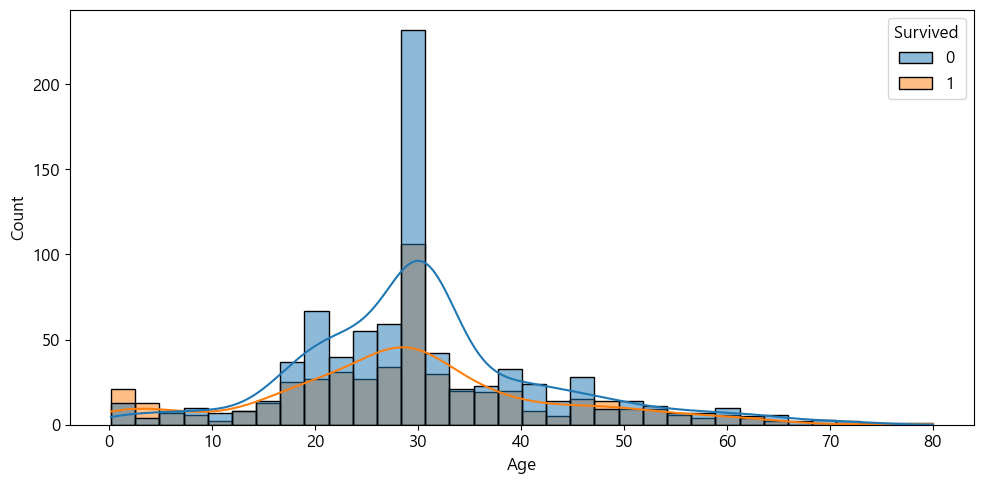

In [9]:
my_histplot(df, 'Age', hue='Survived', dpi=100)

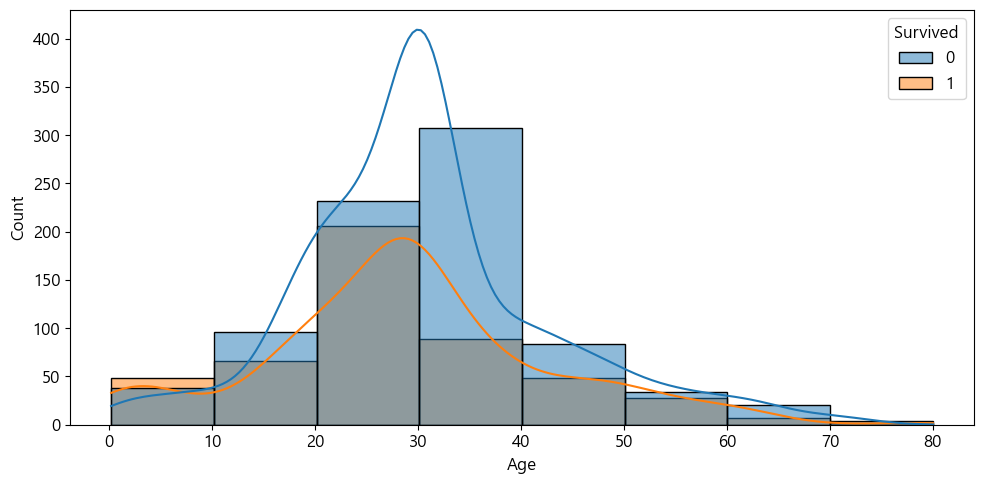

In [10]:
my_histplot(df, 'Age', hue='Survived', bins=8, dpi=100)

In [11]:
hist, bins = np.histogram(df['Age'], bins=5)
print(hist)
print(np.round(bins, 0))

[134 787 269 106  13]
[ 0. 16. 32. 48. 64. 80.]


In [12]:
df2 = df.copy()
df2.loc[ df2['Age'] <= 16, "Age"] = 0
df2.loc[ (df2['Age'] > 16) & (df2['Age'] <= 32), "Age"] = 1
df2.loc[ (df2['Age'] > 32) & (df2['Age'] <= 48), "Age"] = 2
df2.loc[ (df2['Age'] > 48) & (df2['Age'] <= 64), "Age"] = 3
df2.loc[ df2['Age'] > 64, "Age"] = 4

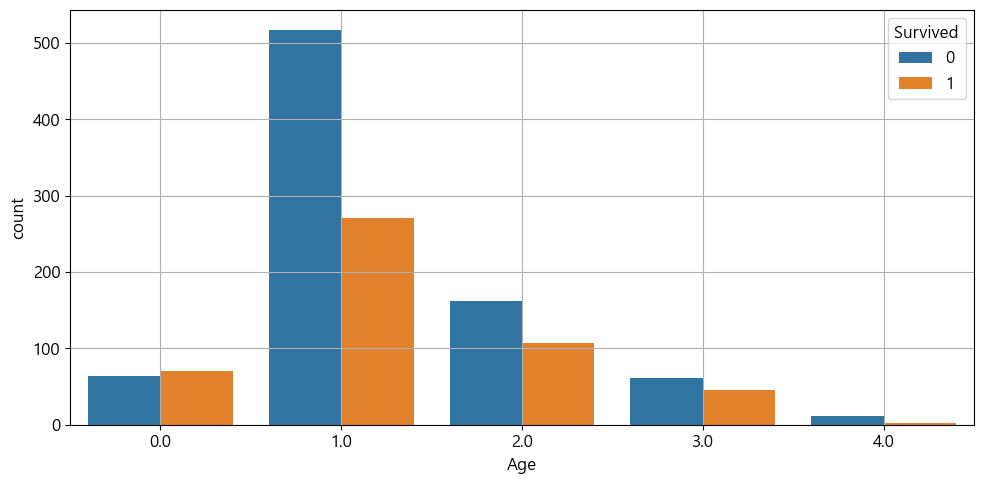

In [13]:
my_countplot(df2, xname='Age', hue='Survived', dpi=100)

In [14]:
# 데이터 타입이 float라 함은 해당 값이 결측치라는 의미 --> 객실이 없다는 뜻
df2['Has_Cabin'] = df2['Cabin'].apply(lambda x: 0 if type(x) == float else 1)
df2['Has_Cabin'].value_counts()

Has_Cabin
0    1014
1     295
Name: count, dtype: int64

In [15]:
# my_stackplot(df2, xname='Has_Cabin', hue='Survived', dpi=100)

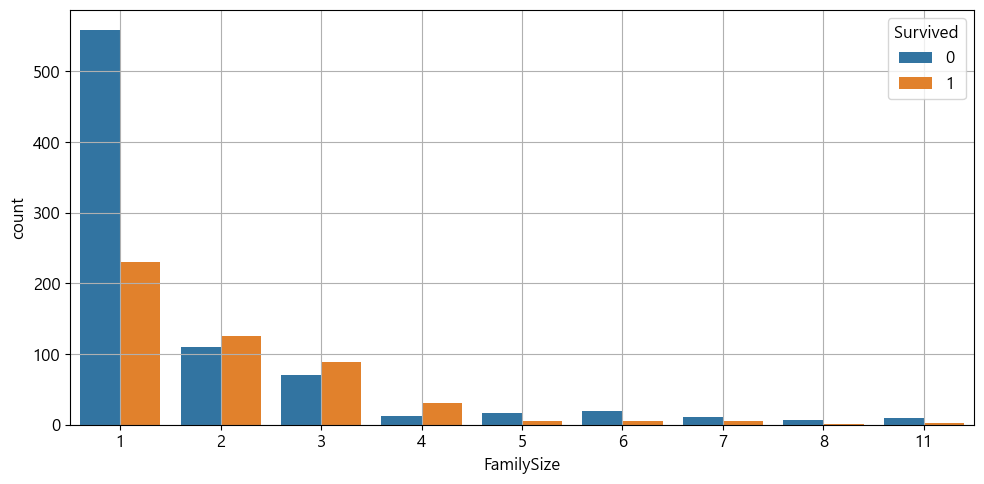

In [16]:
df2['FamilySize'] = df2['SibSp'] + df2['Parch'] + 1
my_countplot(df2, 'FamilySize', hue='Survived', dpi=100)

In [17]:
df2['IsAlone'] = 0
df2.loc[df2['FamilySize'] == 1, 'IsAlone'] = 1

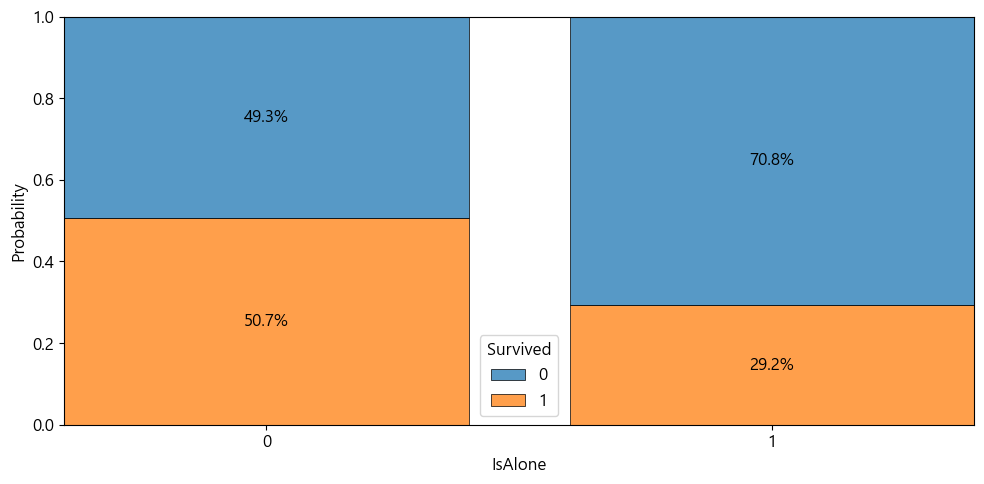

In [18]:
my_stackplot(df2, 'IsAlone', hue='Survived', dpi=100)

In [19]:
most_embarked_df = df2[['Survived','Embarked']].groupby('Survived').agg(pd.Series.mode)
most_embarked_df

,Embarked
Survived,
0,S
1,S


In [20]:
for i in most_embarked_df.index:
    most = most_embarked_df.loc[i]['Embarked']
    #print(most)

    expr = (df2['Survived'] == i) & (df2['Embarked'].isna())
    #print(expr)

    df2.loc[expr, 'Embarked'] = df2.loc[expr, 'Embarked'].fillna(most)

df2['Embarked'].isna().sum()

0

In [21]:
df2['Fare'].isna().sum()

1

In [22]:
mean_fare_df = df2[['Survived','Fare']].groupby('Survived').mean()
mean_fare_df

,Fare
Survived,
0,23.879124
1,48.811497


In [23]:
for i in mean_fare_df.index:
    mean_fare = mean_fare_df.loc[i]['Fare']
    #print(mean_fare)

    expr = (df2['Survived'] == i) & (df2['Fare'].isna())
    #print(expr)

    df2.loc[expr, 'Fare'] = df2.loc[expr, 'Fare'].fillna(mean_fare)

df2['Fare'].isna().sum()

0

In [24]:
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    
    if title_search:
        return title_search.group(1)
    
    return ""

In [25]:
df2['Title'] = df2['Name'].apply(get_title)
df2['Title'].value_counts()

Title
Mr          757
Miss        260
Mrs         197
Master       61
Rev           8
Dr            8
Col           4
Mlle          2
Major         2
Ms            2
Lady          1
Sir           1
Mme           1
Don           1
Capt          1
Countess      1
Jonkheer      1
Dona          1
Name: count, dtype: int64

In [26]:
df2['Title'] = df2['Title'].replace(['Rev', 'Dr', 
                'Mlle', 'Major', 'Col', 'Countess', 'Capt', 'Ms', 
                'Sir', 'Lady', 'Mme', 'Don', 'Jonkheer', 'Dona'], "Rare")

df2['Title'].value_counts()

Title
Mr        757
Miss      260
Mrs       197
Master     61
Rare       34
Name: count, dtype: int64

In [27]:
df3 = my_labelling(df2, 'Title', 'Embarked', 'Sex')
df3.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Has_Cabin,FamilySize,IsAlone,Title
0,1,0,3,"Braund, Mr. Owen Harris",1,1.0,1,0,A/5 21171,7.2500,NaN,2,0,2,0,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2.0,1,0,PC 17599,71.2833,C85,0,1,2,0,3
2,3,1,3,"Heikkinen, Miss. Laina",0,1.0,0,0,STON/O2. 3101282,7.9250,NaN,2,0,1,1,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,2.0,1,0,113803,53.1000,C123,2,1,2,0,3
4,5,0,3,"Allen, Mr. William Henry",1,2.0,0,0,373450,8.0500,NaN,2,0,1,1,2


In [28]:
my_outlier_table(df3, 'Fare')

,Q1,Q2,Q3,IQR,UP,DOWN
FIELD,,,,,,
Fare,7.8958,14.4542,31.275,23.3792,66.3438,-27.173


In [29]:
df3 = yjk_quantile_labeling(df3, 'Fare', 'Fare_bin', False)

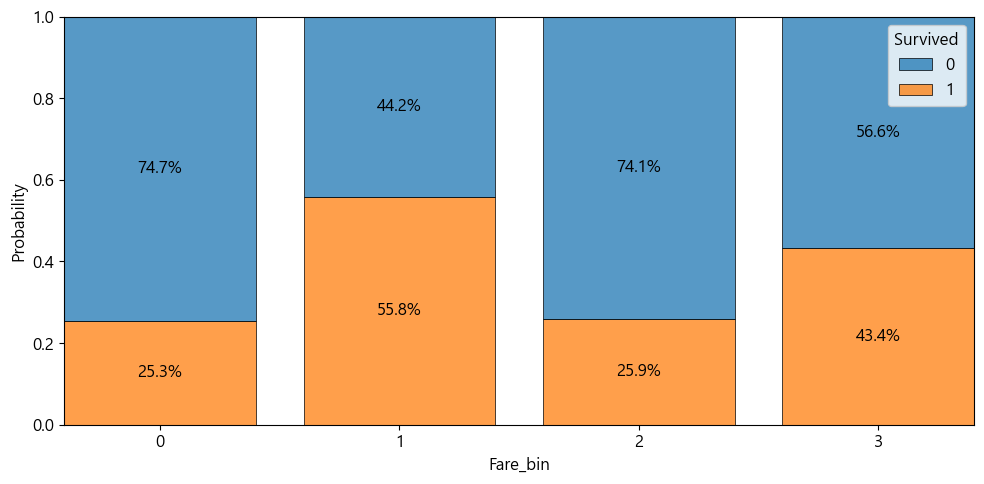

In [30]:
my_stackplot(df3, 'Fare_bin', hue='Survived', dpi=100)

In [31]:
drop_elements = ['Name', 'Ticket', 'Cabin', 'SibSp', 'Parch']
df4 = df3.drop(drop_elements, axis = 1)

my_pretty_table(df4.head())

+----+---------------+------------+----------+-------+-------+---------+------------+-------------+--------------+-----------+---------+------------+
|    |   PassengerId |   Survived |   Pclass |   Sex |   Age |    Fare |   Embarked |   Has_Cabin |   FamilySize |   IsAlone |   Title |   Fare_bin |
|----+---------------+------------+----------+-------+-------+---------+------------+-------------+--------------+-----------+---------+------------|
|  0 |             1 |          0 |        3 |     1 |     1 |    7.25 |          2 |           0 |            2 |         0 |       2 |          0 |
|  1 |             2 |          1 |        1 |     0 |     2 | 71.2833 |          0 |           1 |            2 |         0 |       3 |          3 |
|  2 |             3 |          1 |        3 |     0 |     1 |   7.925 |          2 |           0 |            1 |         1 |       1 |          1 |
|  3 |             4 |          1 |        1 |     0 |     2 |    53.1 |          2 |           1 | 

In [32]:
df4['Survived'] = df4['Survived'].astype('int')
pp = YjkPreprocessor()
pp.set_strategy(outline = None)
df5 = pp.fit_transform(df4, yname = 'Survived')

x_train, x_test, y_train, y_test = my_train_test_split(df5, yname='Survived')
x_train.shape, x_test.shape, y_train.shape, y_test.shape

아래와 같이 처리합니다.
+-------------+----------------+
| 범주        | 처리방법       |
|-------------+----------------|
| 이상치 처리 | 처리하지 않음  |
| 결측치 처리 | 중앙값 대체    |
| 스케일러    | StandardScaler |
| 인코딩      | 원핫인코딩     |
+-------------+----------------+
데이터프레임 크기 : (1309, 12)
데이터프레임에 결측치는 없습니다.
연속형 데이터 컬럼 : ['PassengerId', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked', 'Has_Cabin', 'FamilySize', 'IsAlone', 'Title', 'Fare_bin'], 총 11개
종속변수 컬럼명 : Survived


((1047, 11), (262, 11), (1047,), (262,))

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
| 10 |     1 | l2        |          0.853853 |
| 13 |    10 | l2        |          0.853853 |
| 16 |   100 | l2        |          0.853853 |
|  7 |   0.1 | l2        |          0.851939 |
|  4 |  0.01 | l2        |          0.844297 |
|  1 | 0.001 | l2        |          0.718232 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.438261 |     0.484002 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.854823 |     0.870229 | 예측 결과(TN,FP,TP,TN)가 실제 결과

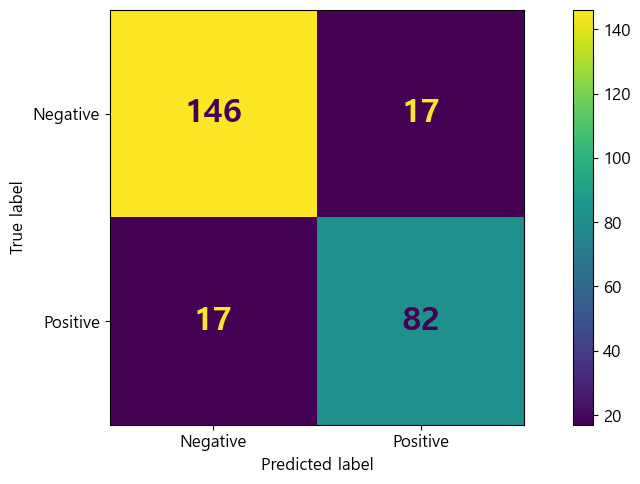


[ROC/PR Curve]


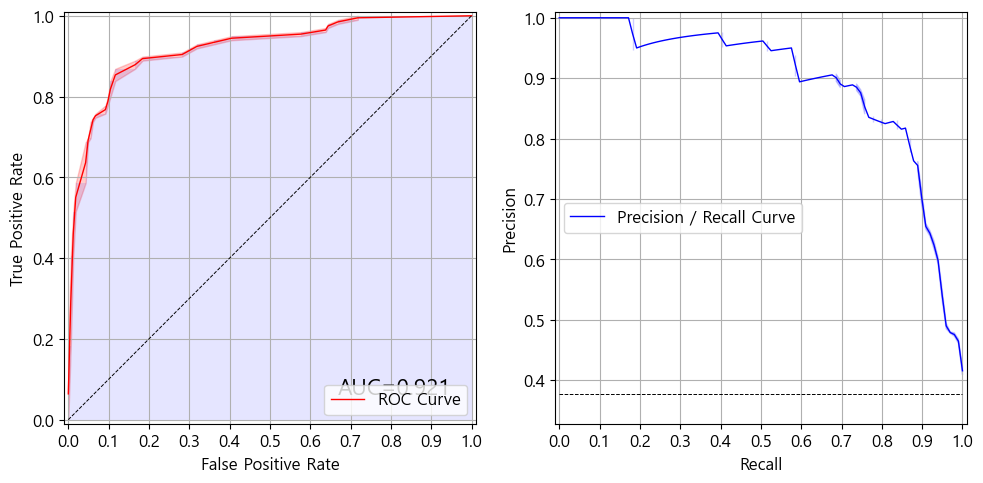


[학습곡선]


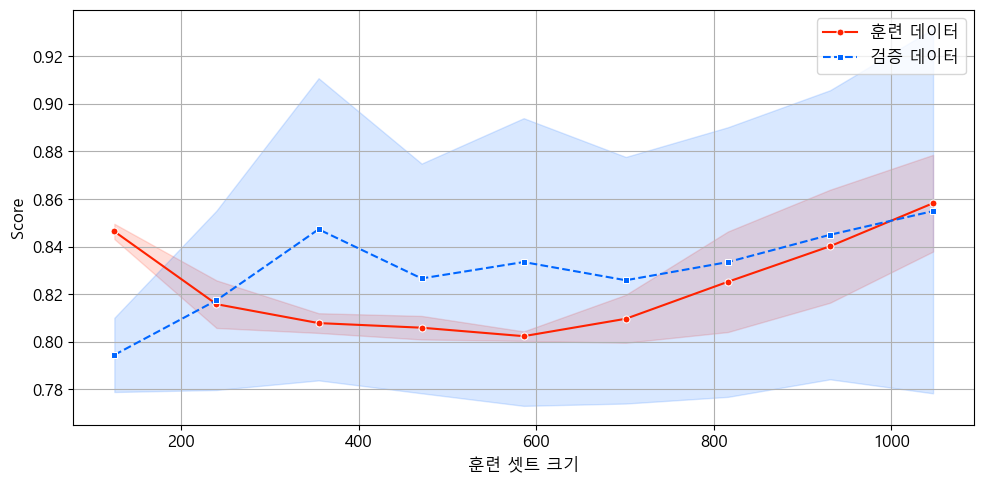

+----+------------+-------------+--------------------+------------+---------+------------+------------+
|    | 종속변수   | 독립변수    |   B(비표준화 계수) |   표준오차 |       t |   유의확률 |   OddsRate |
|----+------------+-------------+--------------------+------------+---------+------------+------------|
|  0 | Survived   | PassengerId |            -0.0409 |      0.184 | -0.2224 |      0.824 |     0.9599 |
|  1 | Survived   | Pclass      |            -0.5155 |      0.336 | -1.5362 |      0.124 |     0.5972 |
|  2 | Survived   | Sex         |            -1.7316 |      0.194 | -8.9344 |          0 |      0.177 |
|  3 | Survived   | Age         |            -0.2533 |      0.229 | -1.1057 |      0.269 |     0.7762 |
|  4 | Survived   | Fare        |             0.0195 |      0.207 |  0.0941 |      0.925 |     1.0197 |
|  5 | Survived   | Embarked    |            -0.0729 |        0.2 | -0.3639 |      0.716 |     0.9297 |
|  6 | Survived   | Has_Cabin   |             0.2218 |      0.249 |  0.8912 |      0.3

In [33]:
estimator = my_logistic_classification(x_train, y_train, x_test, y_test)

In [34]:
df2 = pd.read_excel("./data/imdb.xlsx")

In [35]:
from sklearn.feature_extraction.text import CountVectorizer
import contractions

In [36]:
df2.head()

,sentiment,review
0,positive,One of the other reviewers has mentioned that ...
1,positive,A wonderful little production. <br /><br />The...
2,positive,I thought this was a wonderful way to spend ti...
3,negative,Basically there's a family where a little boy ...
4,positive,"Petter Mattei's ""Love in the Time of Money"" is..."


In [37]:
doc1 = "She likes Python"
doc2 = "She hates Python"

doc2_1 = "Potter likes Singer"
doc2_2 = "Singer likes Potter"

- 문서 단어 행렬 (= 딥러닝의 토큰화)
    - 문장을 문서 단어 행렬로 표현

|| She | likes | hates | Python |
|---|---|---|---|---|
| doc1 | 1 | 1 | 0 | 1 |
| doc2 | 1 | 0 | 1 | 1 |

- 문장을 단어 단위로 쪼개고 단어별로 문장에 몇번 등장하는지 여부를 행렬(=2차 배열)로 작성하여 회귀분석 시행
    - sklearn.feature_extraction.text의 CountVectorizer 객체로 해당 작업 수행
    - 자연어 처리 기타 알고리즘과 딥러닝 (RNN) 등은 대부분 로지스틱 회귀에 근간을 두고 있음
    - 단어 행렬 방식의 단점 : 단어 순서는 판단하지 않기 때문에 다른 의미의 문장이라도 같은 결과가 나올 수 있음
 
|| Potter | likes | Singer |
|---|---|---|---|
| doc2_1 | 1 | 1 | 1 |
| doc2_2 | 1 | 1 | 1 |

In [38]:
count_vec = CountVectorizer()
fit = count_vec.fit_transform([doc1, doc2])
doc_term_matrix = fit.toarray()
doc_term_matrix

array([[0, 1, 1, 1],
       [1, 0, 1, 1]], dtype=int64)

In [39]:
pd.DataFrame(doc_term_matrix, columns = count_vec.get_feature_names_out())

,hates,likes,python,she
0,0,1,1,1
1,1,0,1,1


In [40]:
count_vec = CountVectorizer()
fit = count_vec.fit_transform([doc2_1, doc2_2])
doc_term_matrix = fit.toarray()
doc_term_matrix

array([[1, 1, 1],
       [1, 1, 1]], dtype=int64)

In [41]:
doc1 = 'Python is very good'
doc2 = 'Life is too short, You need Python'

In [42]:
count_vec = CountVectorizer()
fit = count_vec.fit_transform([doc1, doc2])
doc_term_matrix = fit.toarray()
doc_term_matrix

array([[1, 1, 0, 0, 1, 0, 0, 1, 0],
       [0, 1, 1, 1, 1, 1, 1, 0, 1]], dtype=int64)

In [43]:
pd.DataFrame(doc_term_matrix, columns = count_vec.get_feature_names_out())

,good,is,life,need,python,short,too,very,you
0,1,1,0,0,1,0,0,1,0
1,0,1,1,1,1,1,1,0,1


- 문장들에 사용되는 모든 단어를 한꺼번에 나열하여 행렬을 만들기 때문에 변환된 데이터의 크기는 원본보다 커진다.
    - 따라서 머신러닝 학습에 소요되는 리소스가 증가

In [44]:
doc1 = "She likes Python"
doc2 = "She hates Python"

count_vec = CountVectorizer()
fit = count_vec.fit_transform([doc1, doc2])

doc_term_matrix = fit.toarray()
doc_term_matrix

array([[0, 1, 1, 1],
       [1, 0, 1, 1]], dtype=int64)

- 단어 순서 확인

In [45]:
count_vec.vocabulary_

{'she': 3, 'likes': 1, 'python': 2, 'hates': 0}

- 인덱스 순서로 단어를 정렬하여 리턴

In [46]:
count_vec.get_feature_names_out()

array(['hates', 'likes', 'python', 'she'], dtype=object)

- 단어 사전
    - 어떤 단어가 몇 번째 인덱스에 올 것인지 정하는 것
    - fit(fit_transform)을 통하여 단어 사전이 구축되지만 분석가가 필요에 따라 분석 목적에 맞는 단어사전을 미리 정의할 수 있음

- 단어 사전 생성
    - 사전에 포함되지 않은 단어가 문장에 포함될 경우 무조건 '0'번으로 분류됨
        - 사전의 첫번째 단어는 불용어를 의미하는 값으로 정하는 것이 좋음

In [47]:
my_vocabulary = {'ovv' : 0, 'java' : 1, 'html' : 2, 'css' : 3, 'javascript' : 4, 'php' : 5, 'sql' : 6, 'good' : 7}

In [48]:
count_vec = CountVectorizer(
    vocabulary = my_vocabulary, # 단어 사전
    stop_words = ['is', 'to', 'my'], # 분석에서 뺄 단어
    lowercase = True # 소문자 변환 여부 (True로 하면 모든 글자가 소문자로 변환됨)
)

count_vec.vocabulary # 단어사전을 직접 구축하면 단어사전 호출시 _가 빠짐

{'ovv': 0,
 'java': 1,
 'html': 2,
 'css': 3,
 'javascript': 4,
 'php': 5,
 'sql': 6,
 'good': 7}

In [49]:
fit = count_vec.fit_transform([
    'I can do Java, HTML, CSS, Javascript, PHP, Python',
    'Python is good'
])

doc_term_matrix = fit.toarray()
doc_term_matrix

array([[0, 1, 1, 1, 1, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1]], dtype=int64)

- 영어 축약형 표현의 처리 (contractions 패키지)

In [50]:
contractions.fix("you're happy now")

'you are happy now'

In [51]:
contractions.fix("yall're happy now")

'you all are happy now'

In [52]:
contractions.fix("OMG")

'OMG'

In [53]:
contractions.add("OMG", "Oh my god")
contractions.fix("OMG")

'OH MY GOD'

- 데이터 라벨링

In [54]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

In [55]:
df2['sentiment'] = le.fit_transform(df2['sentiment'])

In [56]:
df2.head()

,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. <br /><br />The...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there's a family where a little boy ...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


- 축약어 처리

In [57]:
df2['review'] = df2['review'].apply(lambda x : contractions.fix(x))
df2.head()

,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. <br /><br />The...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there is a family where a little boy...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


- 정규표현식 처리
    - 이메일 주소 제거

In [58]:
import re

In [59]:
def remove_emails(x):
    email_pattern = re.compile(r"(^[a-zA-Z0-9_.+-]+@[a-zA-Z0-9-]+\.[a-zA-Z0-9-.]+$)")
    return re.sub(email_pattern, '', x)

In [60]:
df2['review'] = df2['review'].apply(remove_emails)

In [61]:
df2.head()

,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. <br /><br />The...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there is a family where a little boy...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


- HTML 태그 제거

In [62]:
from bs4 import BeautifulSoup

In [63]:
df2['review'] = df2['review'].apply(lambda x : BeautifulSoup(x).get_text().strip())

In [64]:
df2.head()

,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production. The filming tec...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there is a family where a little boy...
4,1,"Petter Mattei's ""Love in the Time of Money"" is..."


- 특수문자 제거

In [65]:
def remove_special_chars(x):
    x = re.sub(r'[^\w ]+', "", x)
    x = ' '.join(x.split())
    return x

In [66]:
df2['review'] = df2['review'].apply(remove_special_chars)

In [67]:
df2.head()

,sentiment,review
0,1,One of the other reviewers has mentioned that ...
1,1,A wonderful little production The filming tech...
2,1,I thought this was a wonderful way to spend ti...
3,0,Basically there is a family where a little boy...
4,1,Petter Matteis Love in the Time of Money is a ...


- nltk 패키지 (불용어 처리)
    - 불용어 : 의미없는 단어들
    - 불용어 사전 다운로드

In [68]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\yjg10\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

- 데이터에서 불용어 제거

In [69]:
from nltk.corpus import stopwords

In [70]:
sw = stopwords.words('english')
sw[:5]

['i', 'me', 'my', 'myself', 'we']

In [71]:
def remove_stop_words(x):
    global sw
    return ' '.join([word for word in x.split() if word not in sw])

In [72]:
df2['review'] = df2['review'].apply(remove_stop_words)

In [73]:
df2.head()

,sentiment,review
0,1,One reviewers mentioned watching 1 Oz episode ...
1,1,A wonderful little production The filming tech...
2,1,I thought wonderful way spend time hot summer ...
3,0,Basically family little boy Jake thinks zombie...
4,1,Petter Matteis Love Time Money visually stunni...


- 빈도수가 적은 단어 제거
    - 단어 단위 분리하고 Stemming 적용
    - Stemming : 단어들을 원형으로 표현하는 것 (복수형, 단순형, 과거형, 미래형, 동명사 등을 원형으로 변환)

In [74]:
df2['tidy'] = df2['review'].apply(lambda x : x.split())

In [75]:
df2.head()

,sentiment,review,tidy
0,1,One reviewers mentioned watching 1 Oz episode ...,"[One, reviewers, mentioned, watching, 1, Oz, e..."
1,1,A wonderful little production The filming tech...,"[A, wonderful, little, production, The, filmin..."
2,1,I thought wonderful way spend time hot summer ...,"[I, thought, wonderful, way, spend, time, hot,..."
3,0,Basically family little boy Jake thinks zombie...,"[Basically, family, little, boy, Jake, thinks,..."
4,1,Petter Matteis Love Time Money visually stunni...,"[Petter, Matteis, Love, Time, Money, visually,..."


In [76]:
from nltk.stem import PorterStemmer

In [77]:
sample = ['One', 'reviewers', 'mentioned', 'watching']

In [78]:
stemmer = PorterStemmer()

for i in sample:
    print(stemmer.stem(i))

one
review
mention
watch


In [79]:
df2['tidy'] = df2['tidy'].apply(lambda x : [stemmer.stem(i) for i in x])

In [80]:
df2.head()

,sentiment,review,tidy
0,1,One reviewers mentioned watching 1 Oz episode ...,"[one, review, mention, watch, 1, oz, episod, h..."
1,1,A wonderful little production The filming tech...,"[a, wonder, littl, product, the, film, techniq..."
2,1,I thought wonderful way spend time hot summer ...,"[i, thought, wonder, way, spend, time, hot, su..."
3,0,Basically family little boy Jake thinks zombie...,"[basic, famili, littl, boy, jake, think, zombi..."
4,1,Petter Matteis Love Time Money visually stunni...,"[petter, mattei, love, time, money, visual, st..."


In [81]:
all_words = []

for word in df2['tidy']:
    all_words += word

In [82]:
from collections import Counter

In [83]:
all_words[:5]

['one', 'review', 'mention', 'watch', '1']

In [84]:
count_dic = dict(Counter(all_words))
count_dic

{'one': 52579,
 'review': 4186,
 'mention': 2977,
 'watch': 27022,
 '1': 2289,
 'oz': 258,
 'episod': 4827,
 'hook': 577,
 'they': 6273,
 'right': 6657,
 'exactli': 1946,
 'happen': 6920,
 'meth': 104,
 'first': 16819,
 'thing': 16042,
 'struck': 265,
 'brutal': 915,
 'unflinch': 31,
 'scene': 20651,
 'violenc': 1988,
 'set': 7493,
 'word': 3547,
 'go': 18168,
 'trust': 694,
 'show': 19384,
 'faint': 115,
 'heart': 2614,
 'timid': 50,
 'thi': 25744,
 'pull': 1841,
 'punch': 527,
 'regard': 926,
 'drug': 1634,
 'sex': 3228,
 'it': 34481,
 'hardcor': 251,
 'classic': 4132,
 'use': 10031,
 'wordit': 2,
 'call': 5411,
 'nicknam': 83,
 'given': 3497,
 'oswald': 32,
 'maximum': 100,
 'secur': 480,
 'state': 2025,
 'penitentari': 2,
 'focus': 909,
 'mainli': 761,
 'emerald': 14,
 'citi': 2403,
 'experiment': 206,
 'section': 450,
 'prison': 1368,
 'cell': 449,
 'glass': 487,
 'front': 1218,
 'face': 4133,
 'inward': 13,
 'privaci': 25,
 'high': 3835,
 'agenda': 176,
 'them': 82,
 'home': 3661

In [85]:
count_df = pd.DataFrame(pd.Series(count_dic.values(), index = count_dic.keys()), columns = ['count'])

In [86]:
count_df.sort_values('count', ascending = False, inplace = True)

In [87]:
count_df['count'].value_counts()

count
1       122740
2        17597
3         7522
4         4498
5         3054
         ...  
1761         1
1764         1
1776         1
1777         1
1031         1
Name: count, Length: 1782, dtype: int64

In [88]:
pop_word = list(count_df[count_df['count'] > 5].index)

In [89]:
pop_word[:5]

['i', 'movi', 'film', 'the', 'one']

In [90]:
df2['tidy'] = df2['tidy'].apply(lambda x : [i for i in x if i in pop_word])

In [91]:
df2['new_data'] = df2['tidy'].apply(lambda x : " ".join(x))

- 단어행렬 생성

In [92]:
count_vec = CountVectorizer()
fit = count_vec.fit_transform(df2['new_data'])
doc_term_matrix = fit.toarray()
doc_term_matrix[:3]

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [93]:
x_train, x_test, y_train, y_test = train_test_split(fit, df2['sentiment'], test_size = 0.2, random_state = 0, stratify = df2['sentiment'])

[교차검증]
+----+-------+-----------+-------------------+
|    |     C | penalty   |   mean_test_score |
|----+-------+-----------+-------------------|
|  7 |   0.1 | l2        |          0.886444 |
|  4 |  0.01 | l2        |          0.879744 |
| 10 |     1 | l2        |          0.877219 |
| 13 |    10 | l2        |          0.867093 |
| 16 |   100 | l2        |          0.860643 |
|  1 | 0.001 | l2        |          0.857143 |
+----+-------+-----------+-------------------+

[분류분석 성능평가]
+-------------------------+--------------+--------------+-----------------------------------------------------------+
|                         |   훈련데이터 |   검증데이터 | 설명                                                      |
|-------------------------+--------------+--------------+-----------------------------------------------------------|
| 의사결정계수(Pseudo R2) |     0.778352 |     0.589456 | 로지스틱회귀의 성능 측정 지표로, 1에 가까울수록 좋은 모델 |
| 정확도(Accuracy)        |     0.953223 |       0.8885 | 예측 결과(TN,FP,TP,TN)가 실제 결과

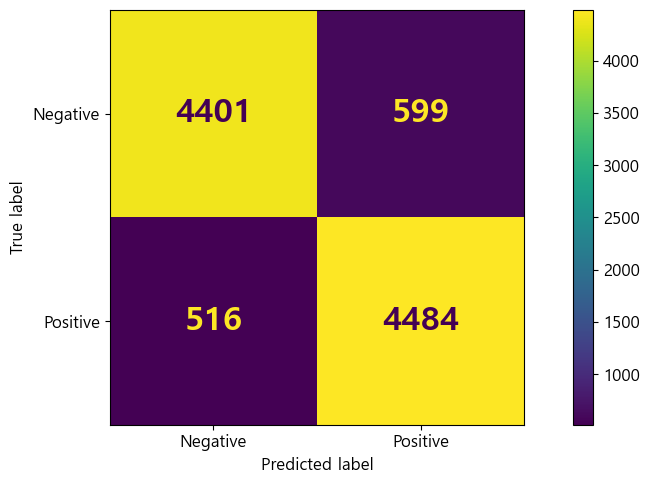


[ROC/PR Curve]


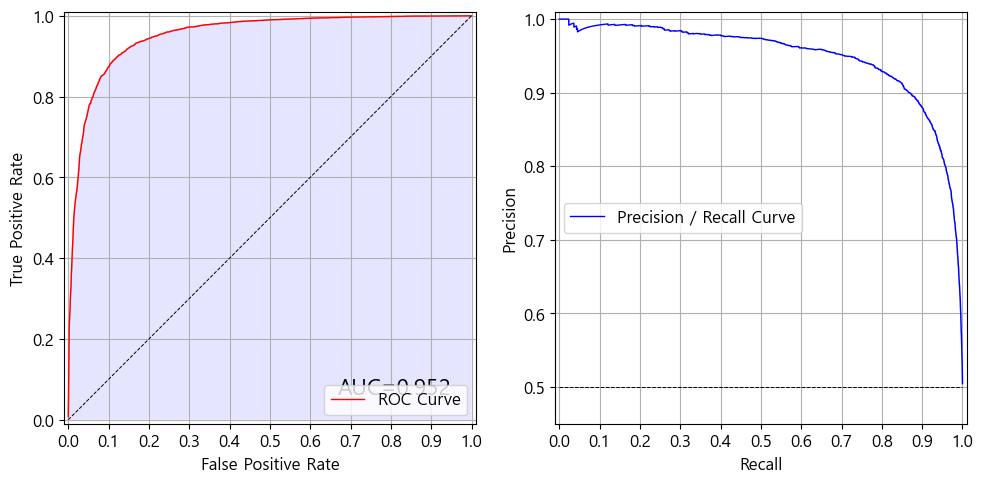

LogisticRegression(C=0.1, max_iter=500, n_jobs=-1)

In [94]:
my_logistic_classification(x_train, y_train, x_test, y_test, report = False, learning_curve = False)